<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization. 

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [2]:
#!python -m spacy download en_core_web_lg -q

In [3]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### NLTK Downloads

In [5]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [6]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [7]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.8.3


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [9]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [10]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [11]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [12]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Loading the Class Corpus

In [13]:
CORPUS_PATH = './data/MSDS453_Sec57_TestQA_ClassCorpus.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [14]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,111,112,113
DSI_Title,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale
Text,The introduction of a new James Bond always br...,Although box office has remained strong worldw...,"Give or take the odd Octopussy, I suppose, lik..."
Submission File Name,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale
Student Name,SPM,SPM,SPM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Casino_Royale,Casino_Royale,Casino_Royale
Descriptor,Action_Casino_Royale_N_111,Action_Casino_Royale_N_112,Action_Casino_Royale_N_113
Doc_ID,111,112,113
raw_sentences,[The introduction of a new James Bond always b...,[Although box office has remained strong world...,"[Give or take the odd Octopussy, I suppose, li..."


## Tokenize Words

In [15]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
111    [introduction, new, james, bond, bring, skepti...
112    [box, office, remain, strong, worldwide, arden...
113    [odd, octopussy, suppose, like, pretty, memora...
115    [love, bond, film, music, gadget, fascinating,...
116    [watch, james, bond, flick, connery, brosnan, ...
Name: lemmas, dtype: object

In [16]:
corpus_df.head(3).T

Doc_ID,111,112,113
DSI_Title,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale
Text,The introduction of a new James Bond always br...,Although box office has remained strong worldw...,"Give or take the odd Octopussy, I suppose, lik..."
Submission File Name,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale
Student Name,SPM,SPM,SPM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Casino_Royale,Casino_Royale,Casino_Royale
Descriptor,Action_Casino_Royale_N_111,Action_Casino_Royale_N_112,Action_Casino_Royale_N_113
Doc_ID,111,112,113
raw_sentences,[The introduction of a new James Bond always b...,[Although box office has remained strong world...,"[Give or take the odd Octopussy, I suppose, li..."


## Reassemble Leminized Words

In [17]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [18]:
corpus_df['lemmas_joined'].head()

Doc_ID
111    introduction new james bond bring skepticism m...
112    box office remain strong worldwide ardent fan ...
113    odd octopussy suppose like pretty memorably fo...
115    love bond film music gadget fascinating woman ...
116    watch james bond flick connery brosnan charact...
Name: lemmas_joined, dtype: object

In [19]:
corpus_df.head(3).T

Doc_ID,111,112,113
DSI_Title,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale
Text,The introduction of a new James Bond always br...,Although box office has remained strong worldw...,"Give or take the odd Octopussy, I suppose, lik..."
Submission File Name,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale
Student Name,SPM,SPM,SPM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Casino_Royale,Casino_Royale,Casino_Royale
Descriptor,Action_Casino_Royale_N_111,Action_Casino_Royale_N_112,Action_Casino_Royale_N_113
Doc_ID,111,112,113
raw_sentences,[The introduction of a new James Bond always b...,[Although box office has remained strong world...,"[Give or take the odd Octopussy, I suppose, li..."


## Vocabulary Data Wrangling

In [20]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 13458
Curated Vocabulary size: 3478


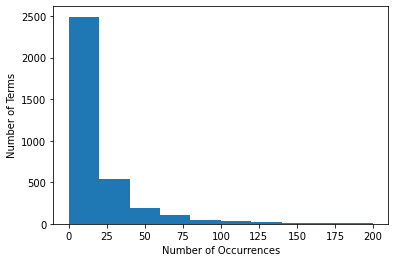

In [21]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [22]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
111    [introduction, new, james, bond, bring, skepti...
112    [box, office, remain, strong, fan, james, bond...
113    [odd, suppose, pretty, forget, memory, process...
115    [love, bond, music, gadget, fascinating, woman...
116    [watch, james, bond, flick, connery, brosnan, ...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words 

In [23]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [24]:
corpus_df.head().T

Doc_ID,111,112,113,115,116
DSI_Title,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale,SPM_Doc6_CasinoRoyale,SPM_Doc7_CasinoRoyale
Text,The introduction of a new James Bond always br...,Although box office has remained strong worldw...,"Give or take the odd Octopussy, I suppose, lik...",What is it that you love about the Bond films?...,I've watched all the James Bond flicks from Co...
Submission File Name,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale,SPM_Doc6_CasinoRoyale,SPM_Doc7_CasinoRoyale
Student Name,SPM,SPM,SPM,SPM,SPM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Casino_Royale,Casino_Royale,Casino_Royale,Casino_Royale,Casino_Royale
Descriptor,Action_Casino_Royale_N_111,Action_Casino_Royale_N_112,Action_Casino_Royale_N_113,Action_Casino_Royale_N_115,Action_Casino_Royale_N_116
Doc_ID,111,112,113,115,116
raw_sentences,[The introduction of a new James Bond always b...,[Although box office has remained strong world...,"[Give or take the odd Octopussy, I suppose, li...",[What is it that you love about the Bond films...,[I've watched all the James Bond flicks from C...


## Review Documents By Movie Title

In [25]:
print(corpus_df['Movie Title'].unique())

['Casino_Royale' 'Mission_Impossible_Fallout'
 'Pirates_of_the_Caribbean_Curse_of_the_Black_Pearl' 'Red_Notice'
 'Speed_Racer' 'Spider_Man_3' 'Sudden_Impact' 'Cruella' 'Encanto'
 'Frozen_2' 'Groundhog_Day' 'KingOfStatenIsland' 'The Martian'
 'Hereditary' 'Lamb' 'Poltergeist' 'The Ring'
 'The_Conjuring_The_Devil_Made_Me_Do_It' 'Us_2019' 'Arrival'
 'Guardians_of_the_Galaxy' 'Interstellar' 'Pacific_Rim'
 'The_Matrix_Resurrecton']


In [26]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Encanto'].copy()
movie_df.head(3).T

Doc_ID,71,73,74
DSI_Title,MLD_Doc2_Encanto,MLD_Doc4_Encanto,MLD_Doc5_Encanto
Text,Walt Disney’s 60th animation boasts songs from...,"Despite my fervent hopes, Disney’s Encanto did...",The animation is a riot of colors wrapped arou...
Submission File Name,MLD_Doc2_Encanto,MLD_Doc4_Encanto,MLD_Doc5_Encanto
Student Name,MLD,MLD,MLD
Genre of Movie,Comedy,Comedy,Comedy
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Encanto,Encanto,Encanto
Descriptor,Comedy_Encanto_N_71,Comedy_Encanto_N_73,Comedy_Encanto_N_74
Doc_ID,71,73,74
raw_sentences,[Walt Disney’s 60th animation boasts songs fro...,"[Despite my fervent hopes, Disney’s Encanto di...",[The animation is a riot of colors wrapped aro...


## Knowledge Graph Extraction

In [27]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'She is voiced by Stephanie Beatriz, who recently had a small role in\xa0Miranda’s musical In the Heights\xa0but is probably still best known for playing the supercool tough cop Diaz in the\xa0TV comedy Brooklyn Nine-Nine.'

In [28]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 306/306 [00:04<00:00, 76.22it/s]


In [29]:
entity_pairs

[['fine voice it', 'contradictory  sparkle'],
 ['', 'canonical Disney Animation Studios'],
 ['creative  it', 'Stepford dream factory'],
 ['contrived  that', 'metaphorical  it'],
 ['somewhere Mirabel encanto', 'enchantment'],
 ['Stephanie who', 'tough TV comedy'],
 ['magical  house', 'great  sadness'],
 ['magic  Abuela', 'magic  which'],
 ['why  she', 'eyesight'],
 ['flowers', 'sheer  loveliness'],
 ['other  sister', 'Jessica buildings'],
 ['aunt', 'cousin hearing'],
 ['he', ''],
 ['', ''],
 ['that', 'gift'],
 ['him', 'own  fightback'],
 ['supernatural  superiority', 'neurotic group unhappiness'],
 ['Maybe  they', 'new  enlightenment'],
 ['So  gifts', ''],
 ['well  abilities', 'well  being'],
 ['broad  they', 'case'],
 ['This', ''],
 ['fervent  Encanto', 'quite  me'],
 ['soon  I', 'clearly  time'],
 ['that', 'solid  idea'],
 ['Lin Manuel Miranda', 'animated  musical'],
 ['where  story', 'location'],
 ['Encanto', 'multigenerational  family'],
 ['magic  story', 'clear  images'],
 ['partic

### Create DataFrame (Source, Target, Edge)

In [30]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [31]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [32]:
kg_df.head(6).T

,0,2,3,4,5,6
source,fine voice it,creative it,contrived that,somewhere mirabel encanto,stephanie who,magical house
target,contradictory sparkle,stepford dream factory,metaphorical it,enchantment,tough tv comedy,great sadness
edge,boasts,feels like,are,is,voiced by,is


In [33]:
len(corpus_text_sentences)

306

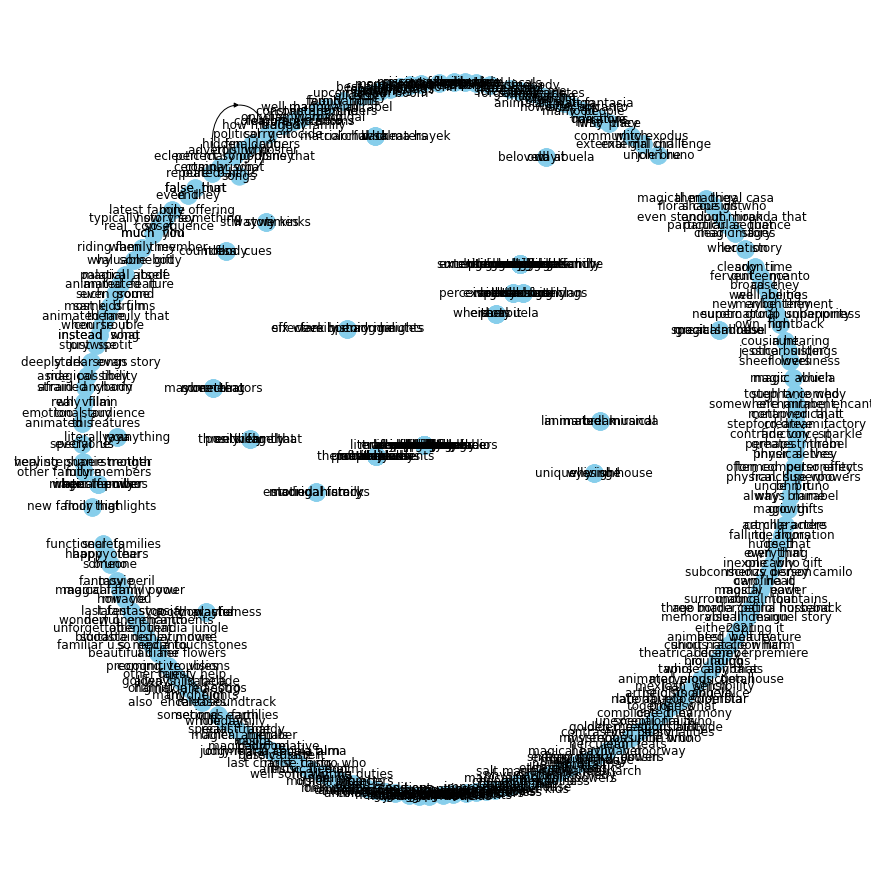

In [34]:
plot_graph(kg_df, use_circular=False)

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [35]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

,0,1,2,3,4
DSI_Title,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale,SPM_Doc6_CasinoRoyale,SPM_Doc7_CasinoRoyale
Text,The introduction of a new James Bond always br...,Although box office has remained strong worldw...,"Give or take the odd Octopussy, I suppose, lik...",What is it that you love about the Bond films?...,I've watched all the James Bond flicks from Co...
Submission File Name,SPM_Doc2_CasinoRoyale,SPM_Doc3_CasinoRoyale,SPM_Doc4_CasinoRoyale,SPM_Doc6_CasinoRoyale,SPM_Doc7_CasinoRoyale
Student Name,SPM,SPM,SPM,SPM,SPM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Casino_Royale,Casino_Royale,Casino_Royale,Casino_Royale,Casino_Royale
Descriptor,Action_Casino_Royale_N_111,Action_Casino_Royale_N_112,Action_Casino_Royale_N_113,Action_Casino_Royale_N_115,Action_Casino_Royale_N_116
Doc_ID,111,112,113,115,116
raw_sentences,[The introduction of a new James Bond always b...,[Although box office has remained strong world...,"[Give or take the odd Octopussy, I suppose, li...",[What is it that you love about the Bond films...,[I've watched all the James Bond flicks from C...


In [36]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet 

In [37]:
data = datafull[['Text','Genre of Movie']].copy()

In [38]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

244    4
245    4
246    4
247    4
248    4
Name: Genre of Movie code, dtype: int8

In [39]:
features, targets = data['Text'], data['Genre of Movie code']
 
train_features, test_features, train_targets, test_targets = train_test_split(features
                                                                              ,targets
                                                                              ,test_size=0.20
                                                                              ,random_state=42
                                                                              ,shuffle = True
                                                                              ,stratify=targets)
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      70
Comedy          1                      60
Horror          3                      60
Sci_Fi          4                      50
Drama           2                       9
dtype: int64

## Create Datasets for Model Development

In [40]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((199, 2), (25, 2), (25, 2))

## Convert DataFrame to TensorFlow DataSet

In [41]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [42]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [43]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 249 non-null    object  
 1   Genre of Movie       249 non-null    category
 2   Genre of Movie code  249 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.8+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [45]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [46]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [47]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '’', 'the', 'film', 's', 'movie', 'i', 'one', '”',
       '“', 'like', 'it', 'time', 'but', 'character', 'make', 'get',
       'even', 'story'], dtype='<U17')

In [48]:
vocab[-20:]

array(['martha', 'marker', 'marked', 'margaret', 'marc', 'mara', 'map',
       'mantra', 'mansion', 'manipulated', 'managing', 'maleficent',
       'majority', 'maitre', 'maintain', 'mailer', 'magnetism', 'madison',
       'maddeningly', 'machination'], dtype='<U17')

## Example of Encoded Words

In [49]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([ 395,  165, 1072,  717, 4341, 1830,  521,  521])

In [50]:
len(encoder.get_vocabulary())

5000

In [51]:
encoder(data['Text'][0])

<tf.Tensor: shape=(527,), dtype=int64, numpy=
array([   3, 3969,   29,  180,   24,  164,  532, 3699,    8,  631,  213,
         24,    5, 1854, 2171,  845,  534, 3699,  788,  547,  448, 1720,
        721, 1593,  740, 2367, 1223,  331,   29, 1049,    1,   24,  331,
          1,    1, 4258, 1092, 2353,    1,  895,    1, 1827,    1,  932,
        464, 1520,  153, 2209,    5, 3217,  135,    5,  153,    5,  691,
         63,  331,  158,   75,  804,   29,   24, 1352,  358,  406,    5,
         29, 2381,   15, 1104, 4923, 4779,  974, 3065, 1923,    1,  790,
        884,  781,   24,    1, 4497,    1,    1, 1493, 2312, 2374, 1168,
         34,  880,  170, 1594,  331,    5,  448,  200,   69,    1,  889,
          1,  153,  135,    6,  917,  440,    1,  163,  551,  158,  646,
       1972, 1388,    5,   21,   24,  688, 1765,   15, 1167, 2960, 1811,
         16,  125,    6, 1881, 2807,    3,    6,  418,   24,    1,    1,
       1886, 1762,   42,  581,  966, 4330,  119,    8, 3076,  271,  233,
     

In [52]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'It \xe2\x80\x99 colourful , boisterous , brimming song magic , yet Disney \xe2\x80\x99 \xe2\x80\x98 Encanto \xe2\x80\x99 far-from-enchanting , little forced , well , rather dull . It \xe2\x80\x99 beautiful look , animation first-class , \xe2\x80\x99 full lovely song quirky character magic , positive messaging community togetherness family value , perfectly honest , latest offering Disney , well , bit bore . One issue emerged lot animated feature late heightened way , story core typically involving something outlandish , weird magical . Encanto turn heightened , crammed full magic lack real punch sense consequence . There \xe2\x80\x99 much magic film kind get bit magicked . Young Mirabel Madrigal ( Stephanie Beatriz ) life magical house magical family person magic gift use make life positively magical community grown around . The magical state affair came magic candle used protect family running ill-defined horseback-riding foe lost family member . But sibling relative specia

## Build RNN Sequential Model 

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [53]:
num_classes=5
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [54]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [55]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
66/66 [==============================] - 96s 1s/step - loss: 1.5454 - accuracy: 0.2525 - val_loss: 1.4639 - val_accuracy: 0.1111
Epoch 2/200
66/66 [==============================] - 75s 1s/step - loss: 1.4475 - accuracy: 0.3283 - val_loss: 1.4236 - val_accuracy: 0.1111
Epoch 3/200
66/66 [==============================] - 75s 1s/step - loss: 1.2307 - accuracy: 0.4697 - val_loss: 1.8750 - val_accuracy: 0.0000e+00
CPU times: user 14min 4s, sys: 19.8 s, total: 14min 24s
Wall time: 4min 7s


## Model Performance Test Accuracy

In [56]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

8/8 [==============================] - 1s 167ms/step - loss: 1.5410 - accuracy: 0.3750
Test Loss: 1.5409826040267944
Test Accuracy: 0.375


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [57]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,1.545,0.253,1.464,0.111
1,1.448,0.328,1.424,0.111
2,1.231,0.470,1.875,0.000


In [59]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

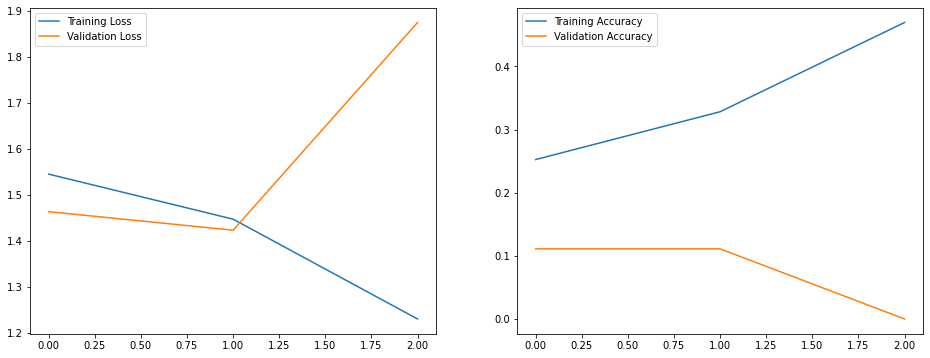

In [60]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion Matrix Post Model Performance Analysis

In [61]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

In [62]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi','Drama']

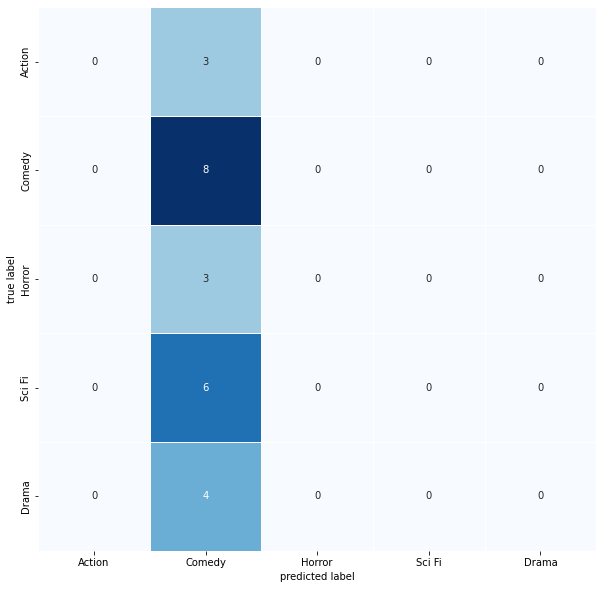

In [63]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [64]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [65]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,36.62%,36.88%,36.64%,36.63%,12.26%,36.81%,12.50%,36.94%,12.38%,12.31%,36.84%,36.78%,36.84%,36.78%,36.56%
Comedy,41.82%,41.57%,41.69%,41.89%,31.25%,41.58%,31.51%,41.62%,31.02%,31.22%,41.63%,41.70%,41.78%,41.91%,41.94%
Horror,2.74%,2.67%,2.67%,2.66%,10.78%,2.64%,10.74%,2.63%,10.73%,11.04%,2.67%,2.65%,2.66%,2.67%,2.69%
Sci Fi,14.55%,14.61%,14.77%,14.65%,24.54%,14.80%,24.38%,14.64%,24.69%,24.17%,14.64%,14.63%,14.52%,14.46%,14.62%
Drama,4.27%,4.26%,4.24%,4.17%,21.16%,4.18%,20.87%,4.16%,21.18%,21.26%,4.23%,4.24%,4.20%,4.18%,4.19%


## RNN Model Architecture

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        